In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import humanize
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
%aimport allel.model
%aimport allel.stats
%aimport allel.opt.stats

In [2]:
gn = np.array([[0, 0, 1, 0, 2, 0, 1, 1, 0],
               [1, 0, 0, 1, 1, 2, 0, 0, 2]], dtype='i1')

In [3]:
np.corrcoef(gn)

array([[ 1.        , -0.39000675],
       [-0.39000675,  1.        ]])

In [4]:
gn_sq = gn ** 2

In [5]:
allel.opt.stats.gn_corrcoef_int8(gn[0], gn[1], gn_sq[0], gn_sq[1])

-0.39000681042671204

In [6]:
gnb = np.random.randint(0, 3, size=(2, 10000)).astype('i1')

In [7]:
np.corrcoef(gnb)

array([[ 1.      , -0.002613],
       [-0.002613,  1.      ]])

In [8]:
gnb_sq = gnb ** 2

In [9]:
allel.opt.stats.gn_corrcoef_int8(gnb[0], gnb[1], gnb_sq[0], gnb_sq[1])

-0.002613014541566372

In [10]:
%timeit np.corrcoef(gnb)

The slowest run took 6.92 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 120 µs per loop


In [11]:
%timeit allel.opt.stats.gn_corrcoef_int8(gnb[0], gnb[1], gnb_sq[0], gnb_sq[1])

The slowest run took 5.16 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 39.9 µs per loop


In [12]:
gnb2 = np.random.randint(0, 3, size=(1000, 1000)).astype('i1')

In [13]:
r2a = np.corrcoef(gnb2)
r2a

array([[ 1.        , -0.05577752,  0.00767298, ..., -0.03381146,
         0.02954236, -0.00755626],
       [-0.05577752,  1.        , -0.02363069, ...,  0.02232033,
         0.06444761,  0.03827147],
       [ 0.00767298, -0.02363069,  1.        , ..., -0.02565621,
         0.00159606,  0.01190215],
       ..., 
       [-0.03381146,  0.02232033, -0.02565621, ...,  1.        ,
        -0.01959978, -0.00503218],
       [ 0.02954236,  0.06444761,  0.00159606, ..., -0.01959978,
         1.        , -0.0092057 ],
       [-0.00755626,  0.03827147,  0.01190215, ..., -0.00503218,
        -0.0092057 ,  1.        ]])

In [14]:
r2b = allel.stats.rogers_huff_r(gnb2)
from scipy.spatial.distance import squareform
r2b_sq = squareform(r2b)
r2b_sq

array([[ 0.        , -0.05577756,  0.00767297, ..., -0.03381132,
         0.02954236, -0.00755618],
       [-0.05577756,  0.        , -0.02363073, ...,  0.02232023,
         0.06444771,  0.03827157],
       [ 0.00767297, -0.02363073,  0.        , ..., -0.02565622,
         0.00159614,  0.01190209],
       ..., 
       [-0.03381132,  0.02232023, -0.02565622, ...,  0.        ,
        -0.01959965, -0.00503222],
       [ 0.02954236,  0.06444771,  0.00159614, ..., -0.01959965,
         0.        , -0.00920562],
       [-0.00755618,  0.03827157,  0.01190209, ..., -0.00503222,
        -0.00920562,  0.        ]])

In [15]:
%timeit np.corrcoef(gnb2)
%memit np.corrcoef(gnb2)

10 loops, best of 3: 110 ms per loop
peak memory: 121.43 MiB, increment: 15.16 MiB


In [16]:
%timeit allel.stats.rogers_huff_r(gnb2)
%memit allel.stats.rogers_huff_r(gnb2)

1 loops, best of 3: 1.84 s per loop
peak memory: 106.46 MiB, increment: 0.00 MiB


In [17]:
import cProfile

In [18]:
cProfile.run('allel.stats.rogers_huff_r(gnb2)', sort='time')

         499538 function calls in 1.885 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   499500    1.789    0.000    1.789    0.000 stats.pyx:17(gn_corrcoef_int8)
        1    0.095    0.095    1.885    1.885 stats.pyx:66(gn_pairwise_corrcoef_int8)
        2    0.000    0.000    0.000    0.000 numeric.py:394(asarray)
        2    0.000    0.000    0.000    0.000 {built-in method array}
        1    0.000    0.000    1.885    1.885 {built-in method exec}
        5    0.000    0.000    0.000    0.000 stringsource:317(__cinit__)
        1    0.000    0.000    1.885    1.885 ld.py:8(rogers_huff_r)
        1    0.000    0.000    1.885    1.885 {allel.opt.stats.gn_pairwise_corrcoef_int8}
        2    0.000    0.000    0.000    0.000 stringsource:957(memoryview_fromslice)
        1    0.000    0.000    1.885    1.885 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 util.py:20(asarray_ndim)
        3    0.000   

##LD pruning 

In [19]:
import random
import numpy as np

def simulate_genotypes_with_ld(n_variants, n_samples, correlation=0.2):
    """A very simple function to simulate a set of genotypes, where
    variants are in some degree of linkage disequilibrium with their
    neighbours.

    Parameters
    ----------

    n_variants : int
        The number of variants to simulate data for.
    n_samples : int
        The number of individuals to simulate data for.
    correlation : float, optional
        The fraction of samples to copy genotypes between neighbouring
        variants.

    Returns
    -------

    gn : ndarray, int8
        A 2-dimensional array of shape (n_variants, n_samples) where each
        element is a genotype call coded as a single integer counting the
        number of non-reference alleles.

    """

    # initialise an array of random genotypes
    gn = np.random.randint(size=(n_variants, n_samples), low=0, high=3)
    gn = gn.astype('i1')

    # determine the number of samples to copy genotypes for
    n_copy = int(correlation * n_samples)

    # introduce linkage disequilibrium by copying genotypes from one sample to
    # the next
    for i in range(1, n_variants):

        # randomly pick the samples to copy from
        sample_indices = random.sample(range(n_samples), n_copy)

        # view genotypes from the previous variant for the selected samples
        c = gn[i-1, sample_indices]

        # randomly choose whether to invert the correlation
        inv = random.randint(0, 1)
        if inv:
            c = 2-c

        # copy across genotypes
        gn[i, sample_indices] = c

    return gn


In [31]:
gnl = simulate_genotypes_with_ld(1000, 1000, .97)
gnl.shape

(1000, 1000)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

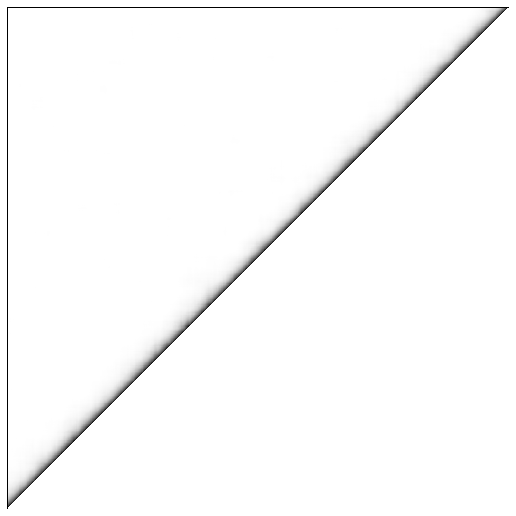

In [33]:
from scipy.spatial.distance import squareform
x = allel.stats.rogers_huff_r(gnl) ** 2
xs = squareform(x)
xs = np.tril(xs)
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.pcolormesh(xs, cmap='Greys', vmin=0, vmax=1)
ax.plot([0, 0], [0, 1], 'k-', transform=ax.transAxes)
ax.plot([0, 1], [1, 1], 'k-', transform=ax.transAxes);

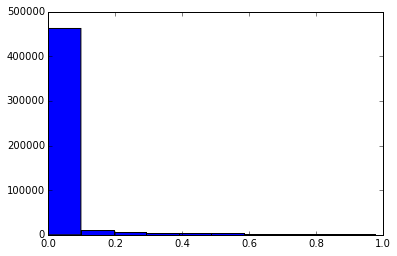

In [34]:
plt.hist(x);

In [39]:
loc = allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.4)

In [40]:
np.count_nonzero(loc)

63

In [41]:
np.nonzero(loc)

(array([  0,  16,  31,  47,  63,  81,  97, 113, 130, 147, 164, 181, 197,
        212, 226, 242, 257, 274, 292, 309, 327, 344, 359, 376, 392, 409,
        425, 441, 455, 471, 486, 503, 521, 536, 551, 566, 580, 594, 611,
        627, 642, 657, 672, 690, 706, 722, 738, 754, 768, 782, 795, 811,
        826, 841, 858, 877, 891, 907, 924, 941, 957, 972, 987]),)

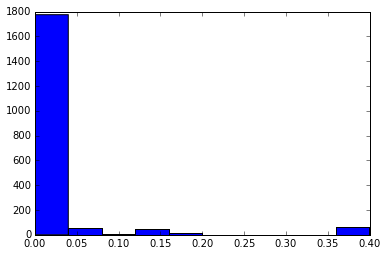

In [42]:
gnu = gnl[loc]
y = allel.stats.rogers_huff_r(gnu) ** 2
plt.hist(y);

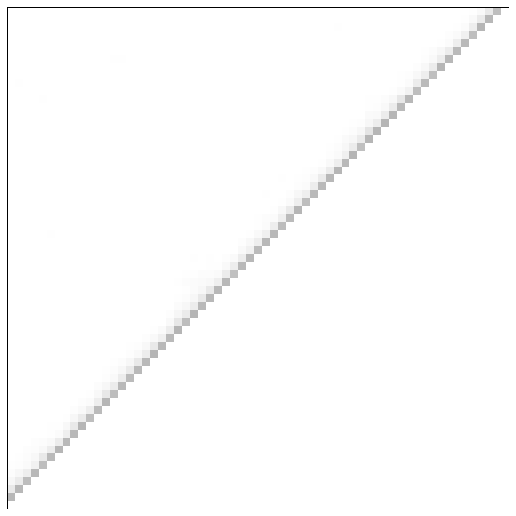

In [43]:
x = allel.stats.rogers_huff_r(gnu) ** 2
xs = squareform(x)
xs = np.tril(xs)
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.pcolormesh(xs, cmap='Greys', vmin=0, vmax=1);
ax.plot([0, 0], [0, 1], 'k-', transform=ax.transAxes)
ax.plot([0, 1], [1, 1], 'k-', transform=ax.transAxes);


In [44]:
%timeit allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.3)
%memit allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.3)

10 loops, best of 3: 35.9 ms per loop
peak memory: 442.50 MiB, increment: 0.00 MiB


In [45]:
import cProfile
cProfile.run('allel.stats.locate_unlinked(gnl, size=100, step=10, threshold=.3)', sort='time')

         110116 function calls in 0.060 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.030    0.030    0.060    0.060 stats.pyx:102(gn_locate_unlinked_int8)
     4403    0.016    0.000    0.016    0.000 stats.pyx:17(gn_corrcoef_int8)
    17614    0.008    0.000    0.010    0.000 stringsource:957(memoryview_fromslice)
    17617    0.001    0.000    0.001    0.000 stringsource:317(__cinit__)
    17617    0.001    0.000    0.001    0.000 stringsource:339(__dealloc__)
    17615    0.001    0.000    0.001    0.000 stringsource:619(memoryview_check)
    17614    0.001    0.000    0.001    0.000 stringsource:933(__dealloc__)
    17614    0.001    0.000    0.001    0.000 stringsource:508(__get__)
        1    0.000    0.000    0.060    0.060 {built-in method exec}
        2    0.000    0.000    0.000    0.000 numeric.py:394(asarray)
        2    0.000    0.000    0.000    0.000 {built-in method array}
        1    0